In [1]:
%config InlineBackend.rc = {"figure.dpi": 150, "figure.figsize": (12.0, 8.0)}
%matplotlib widget

import abtem
import ase
import matplotlib.pyplot as plt
from ase.io import write
import jax
import jax.numpy as jnp
import numpy as np
from jax_multislice import forward_with_scan_positions
import optax
from tqdm.auto import tqdm


(examples:4d-stem_quickstart)=
# 4D-STEM quickstart

In [2]:
abtem.config.set({"device": "cpu"})

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='x [Å]', ylabel='y [Å]'>)

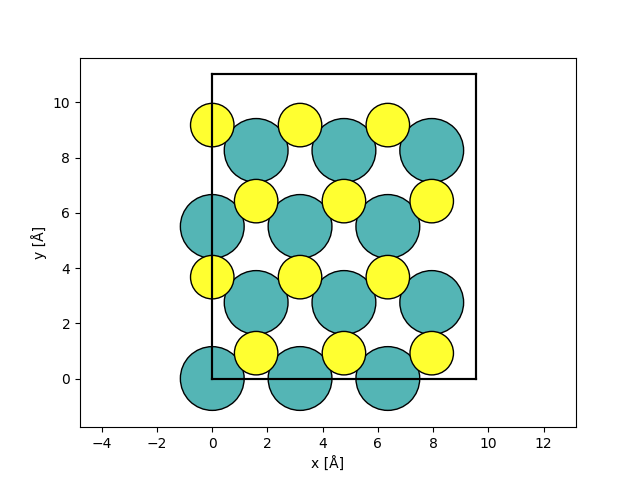

In [3]:
atoms = ase.build.mx2(vacuum=2)

atoms = abtem.orthogonalize_cell(atoms)

atoms *= (3, 2, 1)

abtem.show_atoms(atoms)

In [4]:
potential = abtem.Potential(atoms, sampling=0.1)


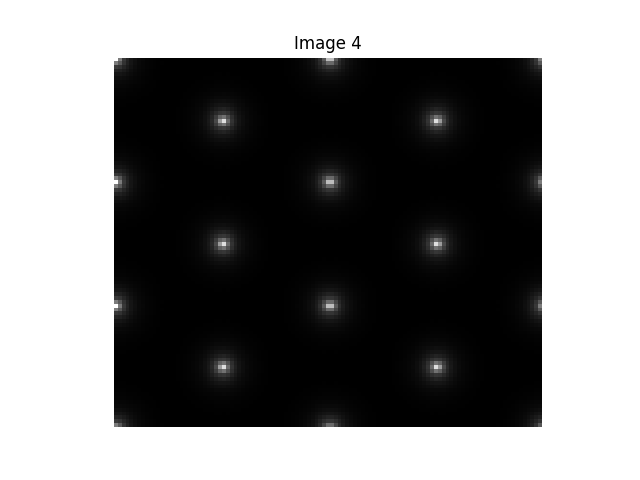

In [5]:
potential.shape
potential_ = potential.to_images()
img = potential_.array[4]

plt.figure()
plt.imshow((jnp.abs(jnp.array(img))), cmap='gray')
plt.title(f'Image {4}')
plt.axis('off')

plt.show()

In [6]:
energy = 80e3
probe = abtem.Probe(energy=energy, semiangle_cutoff=40)
probe.grid.match(potential)

pixels = probe.gpts
pixel_size = probe.sampling

In [7]:
grid_scan = abtem.GridScan(
    start=(0, 0),
    end=(potential.extent[0], potential.extent[1]),
    sampling=probe.aperture.nyquist_sampling,
)

In [8]:
detector = abtem.PixelatedDetector(max_angle='full')

measurements = probe.scan(potential, scan=grid_scan, detectors=detector)
probe_array = probe.build()

In [9]:
patterns = measurements.compute()
abtem_patterns = patterns.abs().array

[########################################] | 100% Completed | 6.09 sms


In [10]:
slice_thickness = jnp.array(potential.slice_thickness[0])
extent=jnp.array(potential.extent)
sampling=jnp.array(potential.sampling)
scan_positions = jnp.array(grid_scan.get_positions())
scan_positions_px = (scan_positions / sampling).astype(jnp.int32)
slices = jnp.array(potential_.array)
probe_array = jnp.array(jnp.array(probe_array.array))

In [ ]:
jax_patterns = forward_with_scan_positions(slices, probe_array, scan_positions_px, energy, sampling, slice_thickness)

In [16]:
print(scan_positions_px.shape)

(37, 43, 2)


Text(0.5, 1.0, 'ABTEM')

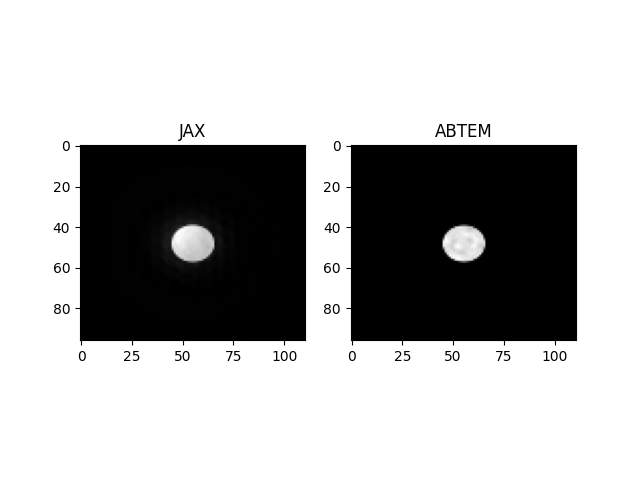

In [12]:
scan_position_x, scan_position_y = 20, 16
fig, ax = plt.subplots(1, 2)
ax[0].imshow(jnp.abs(jax_patterns[scan_position_x, scan_position_y]), cmap='gray')
ax[1].imshow(abtem_patterns[scan_position_x, scan_position_y], cmap='gray')
ax[0].set_title('JAX')
ax[1].set_title('ABTEM')

In [17]:
# @jax.jit
def loss(slices):
    jax_patterns = forward_with_scan_positions(slices, probe_array, scan_positions_px, energy, sampling, slice_thickness)
    return jnp.sum(jnp.sum(jax_patterns - abtem_patterns, axis = (0, 1)))**2

opt_slices = jnp.ones_like(potential_.array, dtype=jnp.complex64)

learning_rate = 100
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(opt_slices)

# @jax.jit
def update(slices, opt_state):
    loss_val, grads = jax.value_and_grad(loss, holomorphic=False)(slices)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_slices = optax.apply_updates(slices, updates)
    return new_slices, new_opt_state, loss_val

num_steps = 1000

losses = []
for step in tqdm(range(num_steps)):
    opt_slices, opt_state, current_loss = update(opt_slices, opt_state)
    print(f"Step {step}, loss: {current_loss}")
    losses.append(current_loss)
    
optimized_slices = opt_slices
print("Optimized slices shape:", optimized_slices.shape)

  0%|          | 0/1000 [00:00<?, ?it/s]

Step 0, loss: 707522816.0
Step 1, loss: 8223919616.0
Step 2, loss: 19074424832.0
Step 3, loss: 53691977728.0
Step 4, loss: 164796317696.0
Step 5, loss: 505097158656.0
Step 6, loss: 1511085703168.0
Step 7, loss: 4411799633920.0


KeyboardInterrupt: 

In [ ]:
def f(z):
  return jnp.sin(z)

z = 3. + 4j
jax.grad(f, holomorphic=True)(z)

Array(-27.034946-3.8511534j, dtype=complex64, weak_type=True)